Esse jupyter notebook apresenta uma ánalise dos dados de doenças cardiacas de um desafio da CybeLabs(https://github.com/cyberlabsai/desafios-machine-learning).

Primeiro foi feito um estudo sobre como uma doença cardíaca é detectada pelos médicos e quais são os exames necessarios para isso.Sabemos que o nivel de colesterol , a frequencia dos batimentos e numeros de veias principais são fatores importantes para determinar se uma pessoa tem a tendencia de ter uma doença cardiovascular

Foi treinado 4 modelos de machine learning nesse notebook(Naive Bayes,Logistic Regression,Random Forest e XGBoost Classifier)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# age - age in years
# trestbps - resting blood pressure (in mm Hg on admission to the hospital)
# chol - serum cholestoral in mg/dl
# restecg - resting electrocardiographic results
# thalach - maximum heart rate achieved
# oldpeak - ST depression induced by exercise relative to rest

# fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
# sex - (1 = male; 0 = female)
# exang - exercise induced angina (1 = yes; 0 = no)
# ca - number of major vessels (0-3) colored by flourosopy ; Value is null

# cp - chest pain type(Value 0: typical angina, Value 1: atypical angina, Value 2: non-anginal pain, Value 3: asymptomatic)
# the slope of the peak exercise ST segment (Value 0: upsloping, Value 1: flat, Value 2: downsloping)
# thal - 0 = null ;1= normal; 2 = fixed defect; 3 = reversable defect


# target - have disease or not (1=yes, 0=no)

# Import the Data

In [3]:
df = pd.read_csv('Mission_Prediction_Dataset.csv')

In [4]:
df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg'
              ,'thalach','exang','oldpeak','slope','ca','thal','target']

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Preprocessing 

In [6]:
#Data Cleaning ca = 4 ou thal = 0  sao valores nulos
df = df[(df['ca']!= 4) & (df['thal']!= 0)]

df['cp'].loc[df['cp'] == 0] = 'typical angina'
df['cp'].loc[df['cp'] == 1] = 'atypical angina'
df['cp'].loc[df['cp'] == 2] = 'non-anginal pain'
df['cp'].loc[df['cp'] == 3] = 'asymptomatic'

df['slope'].loc[df['slope'] == 0] = 'upsloping'
df['slope'].loc[df['slope'] == 1] = 'flat'
df['slope'].loc[df['slope'] == 2] = 'downsloping'

df['thal'].loc[df['thal'] == 1] = 'normal'
df['thal'].loc[df['thal'] == 2] = 'fixed defect'
df['thal'].loc[df['thal'] == 3] = 'reversable defect'

In [7]:
df = pd.get_dummies(df)

# EDA(Exploratory Data Analysis)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 302
Data columns (total 21 columns):
age                       296 non-null int64
sex                       296 non-null int64
trestbps                  296 non-null int64
chol                      296 non-null int64
fbs                       296 non-null int64
restecg                   296 non-null int64
thalach                   296 non-null int64
exang                     296 non-null int64
oldpeak                   296 non-null float64
ca                        296 non-null int64
target                    296 non-null int64
cp_asymptomatic           296 non-null uint8
cp_atypical angina        296 non-null uint8
cp_non-anginal pain       296 non-null uint8
cp_typical angina         296 non-null uint8
slope_downsloping         296 non-null uint8
slope_flat                296 non-null uint8
slope_upsloping           296 non-null uint8
thal_fixed defect         296 non-null uint8
thal_normal               296 non-null


No missing data 

In [9]:
df.describe()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_asymptomatic,cp_atypical angina,cp_non-anginal pain,cp_typical angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
count,296.000000,296.000000,296.00000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,...,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,131.60473,247.155405,0.14527,0.523649,149.560811,0.327703,1.059122,0.679054,...,0.077703,0.165541,0.280405,0.476351,0.466216,0.462838,0.070946,0.550676,0.060811,0.388514
std,9.059471,0.467631,17.72662,51.977011,0.35297,0.526692,22.970792,0.470171,1.166474,0.939726,...,0.268157,0.372297,0.449958,0.500286,0.499702,0.499461,0.257169,0.498268,0.239388,0.488238
min,29.000000,0.000000,94.00000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,120.00000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,130.00000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,61.000000,1.000000,140.00000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,77.000000,1.000000,200.00000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
corr = df.corr('spearman')
corr.style.background_gradient(cmap='coolwarm')

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,target,cp_asymptomatic,cp_atypical angina,cp_non-anginal pain,cp_typical angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
age,1,-0.0918244,0.29725,0.181122,0.126144,-0.129023,-0.394368,0.0908648,0.255632,0.384731,-0.238167,0.0629584,-0.168137,-0.0568975,0.142549,-0.188953,0.175555,0.0261976,-0.138076,0.0648958,0.109094
sex,-0.0918244,1,-0.0569494,-0.147539,0.0369805,-0.0627589,-0.0542115,0.140791,0.107187,0.0995503,-0.285322,0.0914174,-0.0442699,-0.118596,0.090609,-0.0102918,-0.0149548,0.0490424,-0.388233,0.144654,0.325283
trestbps,0.29725,-0.0569494,1,0.133558,0.157819,-0.130639,-0.0491325,0.0558392,0.16257,0.0824516,-0.127025,0.138564,-0.0909491,-0.0315571,0.021793,-0.0775768,0.029821,0.0928216,-0.126943,0.0751605,0.0926993
chol,0.181122,-0.147539,0.133558,1,0.0190193,-0.149893,-0.0368218,0.0865544,0.0293711,0.139281,-0.111472,-0.0500696,-0.00271277,-0.0485001,0.0724774,-0.0134345,0.0343359,-0.0405812,0.0153809,-0.112339,0.0393841
fbs,0.126144,0.0369805,0.157819,0.0190193,1,-0.0796064,-0.00937051,-0.00186319,0.0245429,0.142764,-0.0046796,0.0594076,-0.054642,0.105492,-0.0860599,-0.000909003,-0.0558007,0.11014,-0.070911,0.0956867,0.0254517
restecg,-0.129023,-0.0627589,-0.130639,-0.149893,-0.0796064,1,0.0735674,-0.072324,-0.0741443,-0.120871,0.143199,-0.0715788,0.0830394,0.082489,-0.0976193,0.114644,-0.096871,-0.0346245,0.0232044,-0.0219193,-0.0129339
thalach,-0.394368,-0.0542115,-0.0491325,-0.0368218,-0.00937051,0.0735674,1,-0.404179,-0.435658,-0.289048,0.43154,0.0782154,0.268596,0.162552,-0.388004,0.467132,-0.433335,-0.0660774,0.315922,-0.176637,-0.235805
exang,0.0908648,0.140791,0.0558392,0.0865544,-0.00186319,-0.072324,-0.404179,1,0.294157,0.18032,-0.425085,-0.0951019,-0.2335,-0.259566,0.458192,-0.277352,0.246909,0.0593853,-0.324346,0.0632877,0.299979
oldpeak,0.255632,0.107187,0.16257,0.0293711,0.0245429,-0.0741443,-0.435658,0.294157,1,0.263274,-0.417415,0.107134,-0.320946,-0.0944723,0.266382,-0.572898,0.422963,0.291732,-0.364459,0.113949,0.316076
ca,0.384731,0.0995503,0.0824516,0.139281,0.142764,-0.120871,-0.289048,0.18032,0.263274,1,-0.496139,-0.0625004,-0.161907,-0.137484,0.27764,-0.142912,0.170997,-0.0544101,-0.267792,0.0839019,0.232155


Podemos percerber que o target NAO tem correlação com fbs,cp_asymptomatic,slope_upsloping

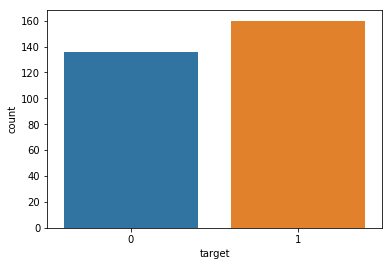

In [11]:
sns.countplot(x = "target", data=df)
plt.show()

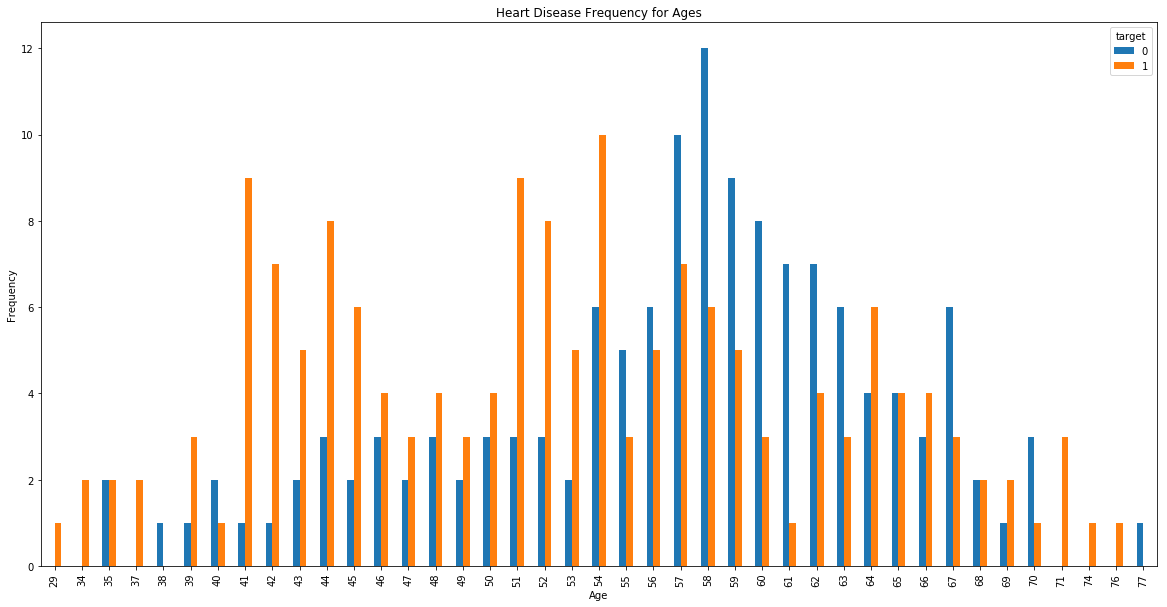

In [12]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,10))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Modeling

A evaluação é feita pela a metrica acurácia

## Splitting the data

In [13]:
target_name = 'target'
data_target = df[target_name]
data = df.drop([target_name], axis=1)

In [14]:
train_x, test_x, train_y, test_y = train_test_split(data, data_target, test_size= 0.3, random_state=0)

## Naive Bayes

In [15]:
gaussian = GaussianNB()
gaussian.fit(train_x, train_y)
acc_gaussian = round(gaussian.score(train_x, train_y) * 100, 2)
acc_gaussian

86.96

In [16]:
acc_test_gaussian = round(gaussian.score(test_x, test_y) * 100, 2)
acc_test_gaussian

84.27

In [17]:
predicted = gaussian.predict(test_x)
print(metrics.classification_report(test_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        45
           1       0.83      0.86      0.84        44

   micro avg       0.84      0.84      0.84        89
   macro avg       0.84      0.84      0.84        89
weighted avg       0.84      0.84      0.84        89



In [18]:
# Store metrics
gaussian_accuracy = metrics.accuracy_score(test_y, predicted)            
gaussian_precision = metrics.precision_score(test_y, predicted, pos_label=1)
gaussian_recall = metrics.recall_score(test_y, predicted, pos_label=1)
gaussian_f1 = metrics.f1_score(test_y, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
gaussian_cv_scores = cross_val_score(GaussianNB(), test_x, test_y, scoring='precision', cv=10)
gaussian_cv_mean = np.mean(gaussian_cv_scores)

## Logistic Regression

In [19]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train_x, train_y)
acc_log = round(logreg.score(train_x, train_y) * 100, 2)
acc_log

89.86

In [20]:
acc_test_log = round(logreg.score(test_x, test_y) * 100, 2)
acc_test_log

84.27

In [21]:
predicted =logreg.predict(test_x)

In [22]:
print(metrics.classification_report(test_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.78      0.83        45
           1       0.80      0.91      0.85        44

   micro avg       0.84      0.84      0.84        89
   macro avg       0.85      0.84      0.84        89
weighted avg       0.85      0.84      0.84        89



In [23]:
# Store metrics
logreg_accuracy = metrics.accuracy_score(test_y, predicted)            
logreg_precision = metrics.precision_score(test_y, predicted, pos_label=1)
logreg_recall = metrics.recall_score(test_y, predicted, pos_label=1)
logreg_f1 = metrics.f1_score(test_y, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logreg_cv_scores = cross_val_score(LogisticRegression(), test_x, test_y, scoring='precision', cv=10)
logreg_cv_mean = np.mean(logreg_cv_scores)

## Random Forest

### Hyperparameter Turning

In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]

# Create the random grid
random_grid = {'n_estimators': n_estimators}

In [25]:
random_forest = GridSearchCV(estimator = RandomForestClassifier(), 
                             param_grid = random_grid, cv = 5)
random_forest.fit(train_x, train_y)
acc_random_forest = round(random_forest.score(train_x, train_y) * 100, 2)
print(acc_random_forest,random_forest.best_params_)


100.0 {'n_estimators': 189}


In [26]:
acc_test_random_forest = round(random_forest.score(test_x, test_y) * 100, 2)
acc_test_random_forest

83.15

In [27]:
predicted = random_forest.predict(test_x)

In [28]:
features = train_x.columns

In [29]:
importances = random_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)

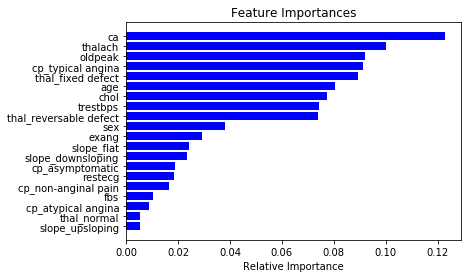

In [30]:
plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')
plt.show()

In [31]:
print(metrics.classification_report(test_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        45
           1       0.80      0.89      0.84        44

   micro avg       0.83      0.83      0.83        89
   macro avg       0.84      0.83      0.83        89
weighted avg       0.84      0.83      0.83        89



In [32]:
# Store metrics
random_forest_accuracy = metrics.accuracy_score(test_y, predicted)            
random_forest_precision = metrics.precision_score(test_y, predicted, pos_label=1)
random_forest_recall = metrics.recall_score(test_y, predicted, pos_label=1)
random_forest_f1 = metrics.f1_score(test_y, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
random_forest_cv_scores = cross_val_score(random_forest, test_x, test_y, scoring='precision', cv=10)
random_forest_cv_mean = np.mean(random_forest_cv_scores)

## XGBoost Classifier

In [33]:
XGB_Classifier = XGBClassifier()
XGB_Classifier.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [34]:
acc_test_xgbclassifier = round(XGB_Classifier.score(test_x, test_y) * 100, 2)
acc_test_xgbclassifier

82.02

In [35]:
predicted = XGB_Classifier.predict(test_x)

<Figure size 1080x1080 with 0 Axes>

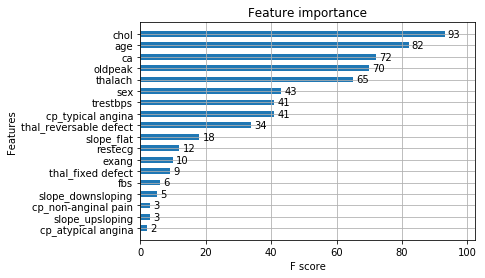

In [36]:
fig =  plt.figure(figsize = (15,15))
xgb.plot_importance(XGB_Classifier,height =0.5)
plt.show();
plt.close()

In [37]:
print(metrics.classification_report(test_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81        45
           1       0.78      0.89      0.83        44

   micro avg       0.82      0.82      0.82        89
   macro avg       0.83      0.82      0.82        89
weighted avg       0.83      0.82      0.82        89



In [38]:
# Store metrics
XGB_Classifier_accuracy = metrics.accuracy_score(test_y, predicted)            
XGB_Classifier_precision = metrics.precision_score(test_y, predicted, pos_label=1)
XGB_Classifier_recall = metrics.recall_score(test_y, predicted, pos_label=1)
XGB_Classifier_f1 = metrics.f1_score(test_y, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
XGB_Classifier_cv_scores = cross_val_score(XGB_Classifier, test_x, test_y, scoring='precision', cv=10)
XGB_Classifier_cv_mean = np.mean(XGB_Classifier_cv_scores)

# Conclusion

Verificamos que as features thal,thalach,cp e ca são features bem importantes para o nosso modelo.

In [40]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'XGBoost Classifier'],
  'Accuracy' : [gaussian_accuracy, logreg_accuracy, random_forest_accuracy, XGB_Classifier_accuracy],
  'Precision': [gaussian_precision, logreg_precision,  random_forest_precision,XGB_Classifier_precision],
  'recall' : [gaussian_recall, logreg_recall,  random_forest_recall,  XGB_Classifier_recall],
  'F1' : [gaussian_f1, logreg_f1,  random_forest_f1, XGB_Classifier_f1],
  'cv_precision' : [gaussian_cv_mean, logreg_cv_mean,  random_forest_cv_mean, XGB_Classifier_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_precision', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_precision
2,Random Forest,0.831461,0.795918,0.886364,0.838710,0.873333
1,Logistic Regression,0.842697,0.800000,0.909091,0.851064,0.815000
3,XGBoost Classifier,0.820225,0.780000,0.886364,0.829787,0.786429
0,Naive Bayes,0.842697,0.826087,0.863636,0.844444,0.726429


Podemos observar que o Random Forest é um dos melhores modelos.(pelo criterio de cv_precision)

Trabalho Futuro: Podemos ainda fazer mais hyperparameter tuning e testar mais modelos.